In [1]:
import numpy as np
from scipy.signal import savgol_coeffs

# Define the window length and polynomial order
window_length = 19
polyorder = 1

# Compute the coefficients
coeffs = savgol_coeffs(window_length, polyorder)

print(coeffs)

[0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]


The above proved that when polyorder is 1, it resembles a simple moving average filter.

We are now going to extend the simple moving average for a more reliable forecast.

For a 15-minute timeframe and window length = 19, we want to predict the next 6 hours for the trend.

Hence the number of data points to forecast = (19-1)/2 + 6 * 4 = 33 ~= 40.

Let's have a validation length of 40 and a forecast length of 40 (40+40).

For seasonal, we have 8+8 using 200 to 800 data length. Let's try 800 to 1600 for trend.

In [1]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_15_minute, n_bars=4000)

prices = forex_data['close']
prices

datetime
2024-09-10 08:02:00    2502.84
2024-09-10 08:17:00    2502.97
2024-09-10 08:32:00    2503.61
2024-09-10 08:47:00    2504.83
2024-09-10 09:02:00    2506.55
                        ...   
2024-11-08 21:47:00    2687.41
2024-11-08 22:02:00    2686.71
2024-11-08 22:17:00    2688.04
2024-11-08 22:32:00    2687.74
2024-11-08 22:47:00    2686.00
Name: close, Length: 4000, dtype: float64

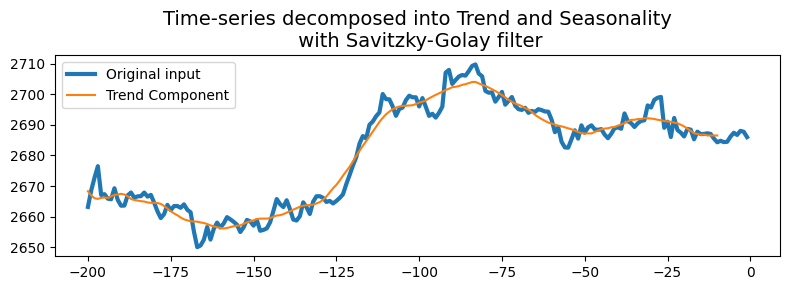

In [102]:
# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

sg_window_length = 19
sg_elements_removed = sg_window_length // 2   # 9 elements removed
yvalues = prices
yvalues_trend = savgol_filter(yvalues,19,1)
yvalues_trend = yvalues_trend[:(len(yvalues_trend)-sg_elements_removed)]   # Remove the extrapolated elements
# yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-200,0), yvalues[-200:], label='Original input',linewidth=3)
#ax.plot(np.arange(-200,0), yvalues_trend[-200:], label='Trend Component')
ax.plot(np.arange(-200,-sg_elements_removed), yvalues_trend[-(200-sg_elements_removed):], label='Trend Component')
#ax.plot(yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

In [66]:
def fft_forecast(signal, forecast_elements, target_harmonics=40, trend_factor=0):
    N = len(signal)
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(N)
    
    # Retain non-negative frequencies
    positive_freq_indices = fft_freq >= 0
    fft_freq_positive = fft_freq[positive_freq_indices]
    fft_result_positive = fft_result[positive_freq_indices]
    
    # Limit the number of harmonics
    num_harmonics = min(target_harmonics, len(fft_freq_positive))
    frequencies = fft_freq_positive[:num_harmonics]
    amplitudes = fft_result_positive[:num_harmonics]
    
    # Create extended indices including future points
    extended_indices = np.arange(N + forecast_elements)
    
    # Reconstruct the signal using the selected harmonics
    reconstructed_signal = np.zeros(N + forecast_elements)
    for i in range(num_harmonics):
        frequency = frequencies[i]
        amplitude_complex = amplitudes[i]
        amplitude = np.abs(amplitude_complex)
        phase = np.angle(amplitude_complex)
        omega = 2 * np.pi * frequency
        
        if frequency == 0:
            # DC component with added trend
            reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
        else:
            reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)
    
    # Add trend component for forecast portion
    if trend_factor != 0:
        trend = np.zeros_like(extended_indices, dtype=float)
        forecast_start = N
        for i in range(len(extended_indices)):
            if i >= forecast_start:
                trend[i] = trend_factor * (i - forecast_start + 1)
        reconstructed_signal += trend
        
    return reconstructed_signal

In [131]:
# Definition of Forecast Parameters
forecast_elements = 40
validation_elements_list = np.arange(8, 24, 2)
trend_harmonics = 60
trend_input_elements_list = np.arange(800, 1600, 4)
trend_gradient_factor_list = np.arange(-0.4, 0.41, 0.1)
visualization_elements = 200

# Initialize a list to store results
results = []

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Generate trend forecasts by looping over different parameters
for validation_elements in validation_elements_list:
    for trend_input_elements in trend_input_elements_list:
        for trend_gradient_factor in trend_gradient_factor_list:
            # Calculate starting index, and get input data slice
            start_idx = len(yvalues_trend) - validation_elements - trend_input_elements
            input_slice = yvalues_trend[start_idx:start_idx+trend_input_elements]

            # Generate forecast with FFT
            yvalues_trend_forecast, num_harmonics = fft_forecast(
                input_slice,
                validation_elements+forecast_elements,
                trend_harmonics,
                trend_gradient_factor
            )
            
            # Convert forecasts to numpy arrays if they're pandas Series
            if isinstance(yvalues_trend_forecast, pd.Series):
                yvalues_trend_forecast = yvalues_trend_forecast.to_numpy()
            if isinstance(yvalues_trend, pd.Series):
                yvalues_trend = yvalues_trend.to_numpy()

            # Extract validation and test portions
            actual_validation = yvalues_trend[-validation_elements:]
            forecast_validation = yvalues_trend_forecast[-validation_elements-forecast_elements:-forecast_elements]

            # Calculate distances
            validation_distance = dtw.distance(actual_validation, forecast_validation)

            # Store the results
            results.append({
                'validation_elements': validation_elements,
                'trend_input_length': trend_input_elements,
                'trend_gradient_factor': trend_gradient_factor,
                'rmse_validation': calculate_rmse(actual_validation, forecast_validation),
                'dtw_validation': validation_distance
            })

results_df = pd.DataFrame(results)
results_df2 = results_df.sort_values(by='dtw_validation', ascending=True).head(20)
results_df2.sort_values(by='rmse_validation', ascending=True).head(10)

,validation_elements,trend_input_length,trend_gradient_factor,rmse_validation,dtw_validation
1504,8,1468,-3.000000e-01,0.242611,0.623975
3294,10,1464,-4.000000e-01,0.293433,0.879358
1505,8,1468,-2.000000e-01,0.351919,0.882412
5085,12,1460,-4.000000e-01,0.369106,0.951698
1516,8,1472,-1.110223e-16,0.377242,0.750378
8649,16,1444,-4.000000e-01,0.406486,1.161304
8640,16,1440,-4.000000e-01,0.430391,0.888264
3295,10,1464,-3.000000e-01,0.437713,1.094617
6876,14,1456,-4.000000e-01,0.474889,0.969271
10459,18,1448,-3.000000e-01,0.566964,0.722834


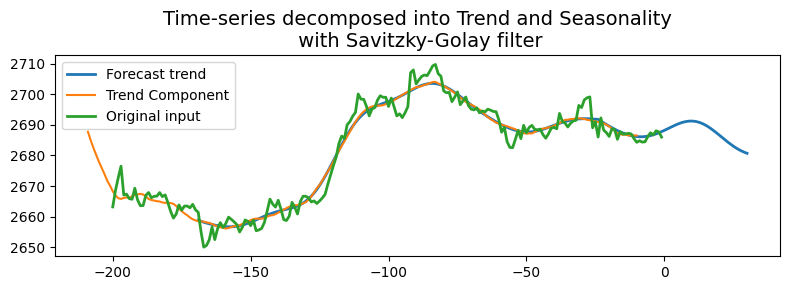

In [125]:
# Generate trend forecast with FFT
validation_elements = 14
trend_input_elements = 1440
trend_harmonics = 60
trend_gradient_factor = -0.5
start_idx = len(yvalues_trend) - validation_elements - trend_input_elements
input_slice = yvalues_trend[start_idx:start_idx+trend_input_elements]
yvalues_trend_forecast, num_harmonics = fft_forecast(
    input_slice,
    validation_elements+forecast_elements,
    trend_harmonics,
    trend_gradient_factor
)

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(np.arange(-visualization_elements+40-sg_elements_removed,40-sg_elements_removed), yvalues_trend_forecast[-visualization_elements:], label='Forecast trend',linewidth=2)
ax.plot(np.arange(-visualization_elements-sg_elements_removed,-sg_elements_removed), yvalues_trend[-visualization_elements:], label='Trend Component')
ax.plot(np.arange(-visualization_elements,0), yvalues[-visualization_elements:], label='Original input',linewidth=2)
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

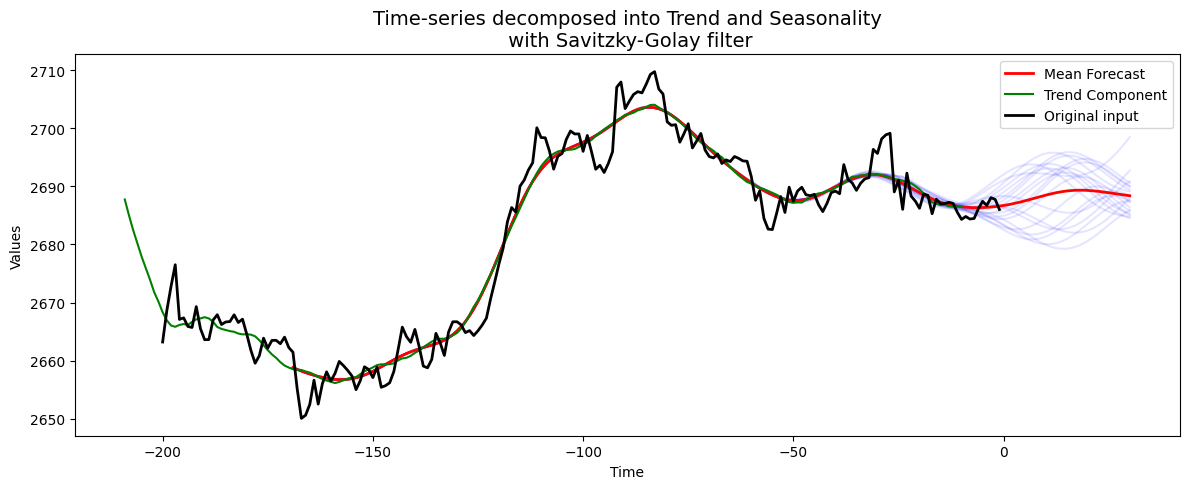

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder for storing all forecasts
all_forecasts = []
plt.figure(figsize=(12, 5))

# Loop through each combination in results_df2
for _, row in results_df2.iterrows():
    trend_harmonics = 60
    # Convert parameters to integers, as they may have been read as float types
    trend_input_elements = int(row['trend_input_length'])
    validation_elements = int(row['validation_elements'])
    trend_gradient_factor = row['trend_gradient_factor']
    
    start_idx = len(yvalues_trend) - validation_elements - trend_input_elements
    input_slice = yvalues_trend[start_idx:start_idx+trend_input_elements]
    
    # Generate trend forecast with FFT
    yvalues_trend_forecast, num_harmonics = fft_forecast(
        input_slice,
        validation_elements + forecast_elements,
        trend_harmonics,
        trend_gradient_factor
    )
    
    # Store the forecast in all_forecasts
    all_forecasts.append(yvalues_trend_forecast[-visualization_elements:])
    
    # Plot each individual forecast with alpha=0.2
    plt.plot(np.arange(-visualization_elements+40-sg_elements_removed, 40-sg_elements_removed), yvalues_trend_forecast[-visualization_elements:], 
             color='blue', alpha=0.1)

# Calculate the mean forecast across all cases
mean_forecast = np.mean(all_forecasts, axis=0)

# Plot the mean forecast in a distinct color
plt.plot(np.arange(-visualization_elements+40-sg_elements_removed, 40-sg_elements_removed), mean_forecast, 
         color='red', linewidth=2, label='Mean Forecast')

# Plot original trend and input data
plt.plot(np.arange(-visualization_elements-sg_elements_removed, -sg_elements_removed), yvalues_trend[-visualization_elements:], 
         label='Trend Component', color='green')
plt.plot(np.arange(-visualization_elements, 0), yvalues[-visualization_elements:], 
         label='Original input', color='black', linewidth=2)

# Add legend and labels
plt.legend()
plt.title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Values')
plt.tight_layout()
plt.show()


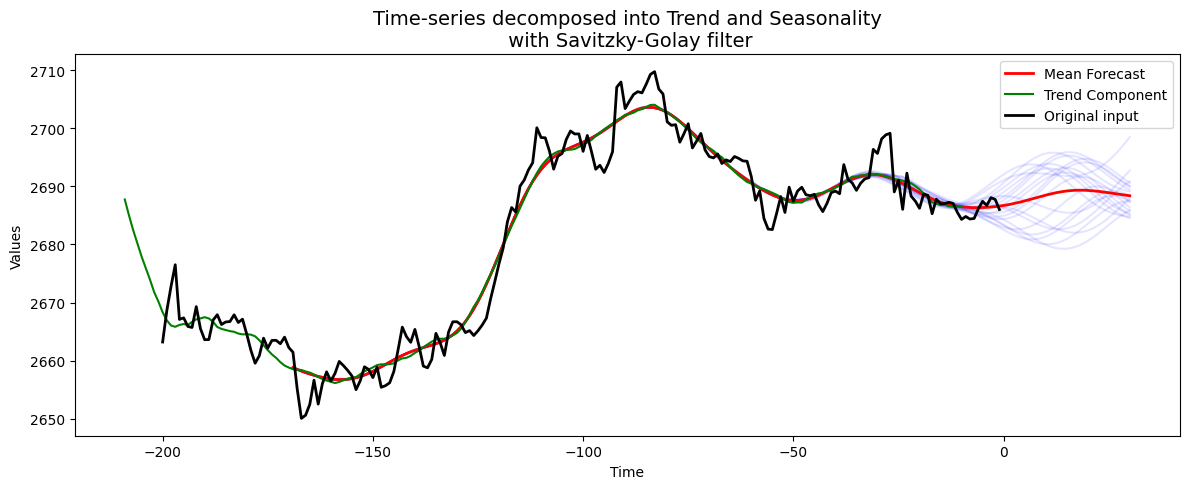

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder for storing all forecasts
all_forecasts = []
plt.figure(figsize=(12, 5))

# Loop through each combination in results_df2
for _, row in results_df2.iterrows():
    trend_harmonics = 60
    # Convert parameters to integers, as they may have been read as float types
    trend_input_elements = int(row['trend_input_length'])
    validation_elements = int(row['validation_elements'])
    trend_gradient_factor = row['trend_gradient_factor']
    
    # Calculate starting index based on trend input and validation elements
    start_idx = len(yvalues_trend) - validation_elements - trend_input_elements
    input_slice = yvalues_trend[start_idx:start_idx + trend_input_elements]
    
    # Generate trend forecast with FFT
    yvalues_trend_forecast, num_harmonics = fft_forecast(
        input_slice,
        validation_elements + forecast_elements,
        trend_harmonics,
        trend_gradient_factor
    )
    
    # Store the forecast in all_forecasts (ensure consistent length by slicing)
    all_forecasts.append(yvalues_trend_forecast[-visualization_elements:])
    
    # Plot each individual forecast with alpha=0.1 for transparency
    plt.plot(np.arange(-visualization_elements + forecast_elements - sg_elements_removed, forecast_elements - sg_elements_removed), 
             yvalues_trend_forecast[-visualization_elements:], 
             color='blue', alpha=0.1)

# Calculate the mean forecast across all cases
mean_forecast = np.mean(all_forecasts, axis=0)

# Plot the mean forecast in a distinct color
plt.plot(np.arange(-visualization_elements + forecast_elements - sg_elements_removed, forecast_elements - sg_elements_removed), mean_forecast, 
         color='red', linewidth=2, label='Mean Forecast')

# Plot original trend and input data for comparison
plt.plot(np.arange(-visualization_elements - sg_elements_removed, -sg_elements_removed), yvalues_trend[-visualization_elements:], 
         label='Trend Component', color='green')
plt.plot(np.arange(-visualization_elements, 0), yvalues[-visualization_elements:], 
         label='Original input', color='black', linewidth=2)

# Add legend, labels, and finalize plot
plt.legend()
plt.title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Values')
plt.tight_layout()
plt.show()
